## CLIP ViT-B/32 + Ridge Baseline (PetFinder Pawpularity)

This notebook extracts **CLIP ViT-B/32** embeddings for all photos in `data/raw/{train,test}`, fits a **RidgeCV** regressor on the training embeddings to predict the **Pawpularity** score (0–100).
Features are cached under `data/processed/` (e.g., `clip_vitb32_train.npy`, `clip_vitb32_test.npy`) using labels from `data/train.csv`.

**Pipeline**
- Encode images with CLIP ViT-B/32 (L2-normalize embeddings).
- Train **RidgeCV** (with standardized features) on `Pawpularity`.
- Predict on test, clip to `[0, 100]`, save `submission.csv`.

**Purpose**
A fast, reproducible baseline to validate paths, IDs, and the overall workflow before scaling to multi-backbone SVR and blending.



### Imports & device

- Imports the libraries we’ll use (filesystem/URL utils, NumPy/Pandas, Matplotlib, PIL for images).
- Imports PyTorch and auto-selects the best compute device:
  - **MPS** on Apple Silicon (Mac GPU),
  - else **CUDA** if an NVIDIA GPU is available,
  - otherwise **CPU**.
- Prints the chosen device so we know where inference will run.

Note: `ssl` and `urllib.request` are included for any HTTPS downloads in later cells.


In [1]:
import sys; print(sys.executable)

/venv/main/bin/python


In [2]:
import os, sys, subprocess, ssl, urllib.request
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Ensure CLIP lib + local weights (via Kaggle dataset)

- **Installs CLIP** from GitHub (safe to re-run; no effect if already installed).
- **Ensures the Kaggle CLI is available** (used to fetch model weights).
- **Creates a local assets folder** at `../assets/clip/`.
- **Looks for the CLIP ViT-B/32 weights** file (`ViT-B-32.pt`) under that folder.
- **If missing, downloads a weights bundle from Kaggle** (tries a few known datasets), then unzips it and locates `ViT-B-32.pt`.  
  Why Kaggle? This avoids direct HTTPS downloads from OpenAI’s servers and sidesteps SSL issues.
- **Fails fast with a clear message** if the weights still can’t be found, telling you to place `ViT-B-32.pt` manually in `../assets/clip/`.
- **Prints the resolved local path** to the weights so later cells can load CLIP with:
  ```python
  model, preprocess = clip.load(str(weight_path), device=device)


In [5]:
import os, sys, zipfile, subprocess
from pathlib import Path

# Ensure Kaggle package is installed in THIS kernel
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "kaggle"])

# Credentials: ~/.kaggle/kaggle.json OR env vars KAGGLE_USERNAME/KAGGLE_KEY
kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)
cred = kaggle_dir / "kaggle.json"
if not cred.exists() and not (os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY")):
    raise FileNotFoundError(
        f"Missing {cred} and no KAGGLE_USERNAME/KAGGLE_KEY set. Upload kaggle.json or set the env vars, then re-run."
    )
if cred.exists():
    os.chmod(cred, 0o600)

# Where to put weights
ASSETS = Path("../assets/clip"); ASSETS.mkdir(parents=True, exist_ok=True)

def find_weights():
    m = list(ASSETS.rglob("ViT-B-32.pt"))
    return m[0] if m else None

weight_path = find_weights()

# Try Kaggle API (no shell CLI)
if weight_path is None:
    from kaggle.api.kaggle_api_extended import KaggleApi
    api = KaggleApi(); api.authenticate()

    for slug in [
        "titericz/openaiclipweights",
        "thedevastator/openaiclip-weights",
        "singhaltarun/openaiclip-vit-base-patch32",
        "takiholadi/clip-vit-base-patch32",
    ]:
        try:
            print("Downloading:", slug)
            api.dataset_download_files(slug, path=str(ASSETS), unzip=True, quiet=False)
            weight_path = find_weights()
            if weight_path: break
        except Exception as e:
            print("  -> failed:", type(e).__name__, e)

# Fallback: let CLIP download from its mirror
if weight_path is None:
    print("Kaggle failed; trying clip.load() fallback…")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "git+https://github.com/openai/CLIP.git"])
    import clip
    _model, _preproc = clip.load("ViT-B/32", device="cpu", download_root=str(ASSETS))
    weight_path = find_weights()

if weight_path is None:
    raise FileNotFoundError("Still no ViT-B-32.pt. You can also drop it manually into ../assets/clip/ and re-run.")

print("Local weight file:", weight_path)


Downloading: titericz/openaiclipweights
Dataset URL: https://www.kaggle.com/datasets/titericz/openaiclipweights


100%|██████████| 1.99G/1.99G [00:00<00:00, 12.2GB/s]

Local weight file: ../assets/clip/clip/CLIP/models/ViT-B-32.pt


### Load CLIP from the local file

- Imports the `clip` package and **loads the CLIP model + preprocessing transform** using the previously resolved `weight_path` (e.g., `../assets/clip/ViT-B-32.pt`).
- Places the model on the selected **device** (`mps`/`cuda`/`cpu`) and switches to **eval mode** (`model.eval()`), which disables training-only layers like dropout.
- Exposes:
  - `model`: for encoding images/text to CLIP embeddings
  - `preprocess`: the exact torchvision transform CLIP expects

Why local load? It avoids any HTTPS download (handy on networks with SSL issues). If this cell errors, ensure `weight_path` points to a valid `ViT-B-32.pt` from the previous step.


In [6]:
import clip

print("Loading CLIP (local weights)…")
model, preprocess = clip.load(str(weight_path), device=device)
model.eval();

Loading CLIP (local weights)…


### list available models + show where weights live

- Prints the **model names** that the installed `clip` package knows about (`clip.available_models()`), e.g., `["RN50", "RN101", "ViT-B/32", ...]`.  
  Note: These are identifiers; we’re still loading **local** weights via `weight_path`.
- Prints the **folder containing your local weights** so you can confirm the path resolved correctly (e.g., `../assets/clip/...`).

Use this to quickly verify your environment.  
If the models list is empty or the path looks wrong, re-run the previous setup cell or check that `ViT-B-32.pt` exists under `../assets/clip/`.


In [7]:
print("Available CLIP models:", clip.available_models())
print("Weights folder:", Path(weight_path).parent)

Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Weights folder: ../assets/clip/clip/CLIP/models


### Queries

This cell declares the **list of text prompts** that each image will be scored against with CLIP.  
Edit this list to explore concepts you care about.

**Tips**
- Keep prompts short and concrete (e.g., “a dog”, “a sleeping cat”).
- Include contrasting pairs to make ranks meaningful (e.g., “animal inside a car” vs “animal outside a car”).
- Add task-specific prompts for PetFinder ideas:  
  - “close-up pet portrait”, “pet with human”, “indoor photo”, “outdoor photo”  
  - “bright lighting”, “blurred image”, “occluded face”, “multiple animals”
- You can add many prompts; CLIP will tokenize them and return cosine similarity per prompt.

> Repro note: Treat this list as part of your experiment config so results are comparable across runs.


In [8]:
QUERIES = [
    "a dog",
    "a cat",
    "a elephant",
    "a zebra",
    "a sleeping dog",
    "a sleeping cat",
    "a giraffe",
    "a poodle",
    "animal inside a car",
    "animal outside a car",
    "a sofa",
    "some animals",
    "santa claus",
    "ipod",
    "two mugs",
    "three mugs",
    "blue sky",
]


### Robust CLIP Demo: Fetch Images → 256×256 Viewer → Text-Query Scoring.

- **Loads CLIP locally** (no HTTPS download): expects `../assets/clip/ViT-B-32.pt` and selects the best device (**MPS** on Apple Silicon, else **CUDA**, else **CPU**).
- **Fetches 6 sample images** from Flickr with a **429-safe exponential backoff** (via `curl`, proper headers, and file verification).  
  If any download fails, it **falls back** to your local PetFinder training images in `../data/raw/train/`.
- **Displays each image at 256×256 with pixel ticks** (like the GM notebook preview) using `show256(...)`.
- **Pre-encodes prompts** in `QUERIES`, computes **CLIP cosine similarities** for each image, and prints a **ranked table** (highest score first).
- Uses **AMP only on CUDA** (quiet on MPS/CPU) and guards against truncated files.

**Prereqs**
- `../assets/clip/ViT-B-32.pt` present (fetched earlier via Kaggle).
- PetFinder data under `../data/raw/` (`train.csv`, `train/`, etc.) for the fallback path.

**Customize**
- Edit `QUERIES` to try your own prompts (e.g., “indoor photo”, “multiple animals”, “blurry image”).


Device: cuda
Images to score: ['demo_images/6426668771_b5b915e46c_o.jpg', 'demo_images/10806045045_02d3dbdcee_o.jpg', 'demo_images/2888764405_0a0a608604_o.jpg', 'demo_images/4294212194_a49663b2b9_o.jpg', 'demo_images/8019508216_6540c8686a_o.jpg', 'demo_images/1357102390_943c5cb999_o.jpg']


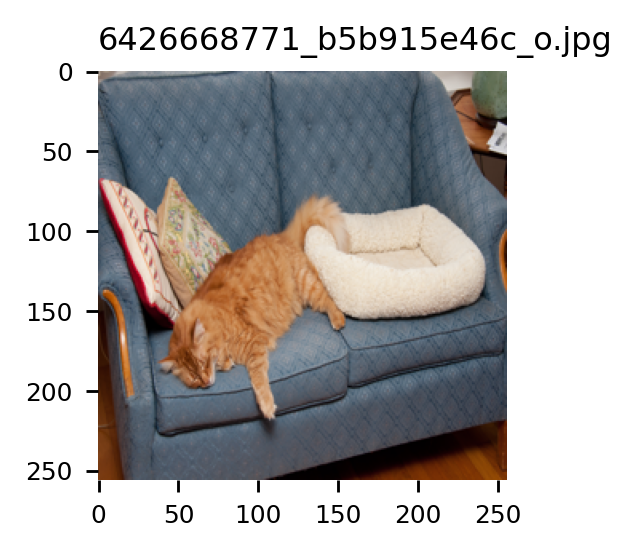

,query,score
0,a sofa,0.268311
1,a sleeping cat,0.259277
2,a cat,0.237061
3,a sleeping dog,0.222656
4,a dog,0.203003
5,two mugs,0.197144
6,some animals,0.197021
7,a poodle,0.194092
8,three mugs,0.193481
9,a giraffe,0.188354


------------------------------------------------------------


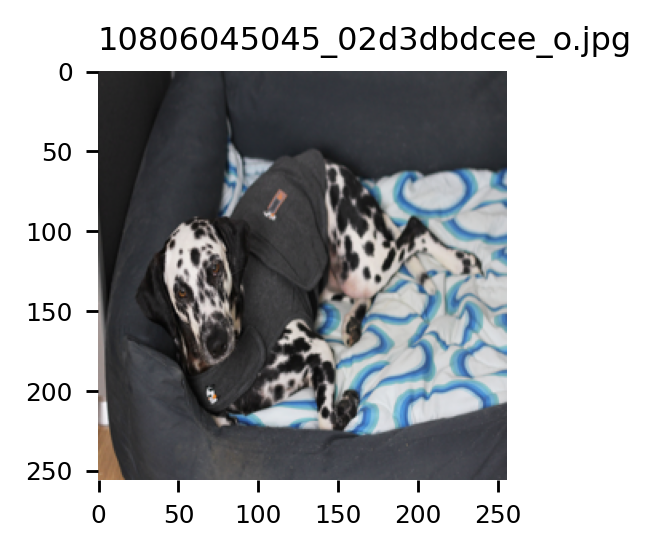

,query,score
0,a sleeping dog,0.256836
1,a dog,0.235840
2,a sofa,0.219238
3,a poodle,0.216309
4,animal inside a car,0.205200
5,a giraffe,0.204224
6,a zebra,0.199829
7,a sleeping cat,0.198975
8,a elephant,0.194336
9,animal outside a car,0.190674


------------------------------------------------------------


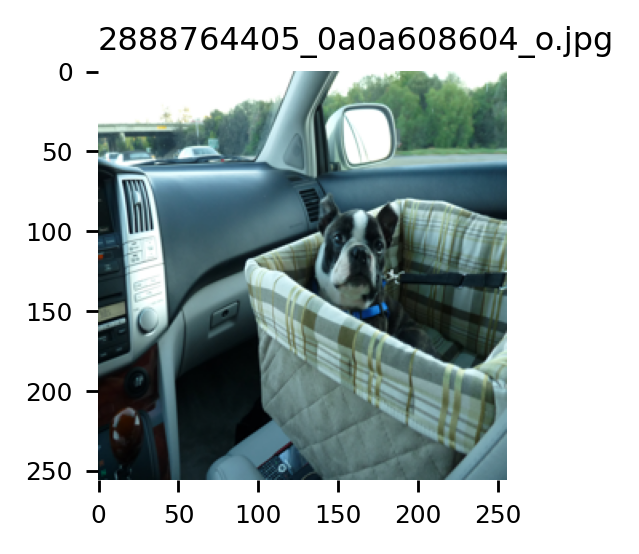

,query,score
0,animal inside a car,0.267578
1,animal outside a car,0.249756
2,a sleeping dog,0.243774
3,a dog,0.238892
4,a sofa,0.228760
5,a poodle,0.206421
6,ipod,0.206177
7,some animals,0.192505
8,a zebra,0.191772
9,a sleeping cat,0.188843


------------------------------------------------------------


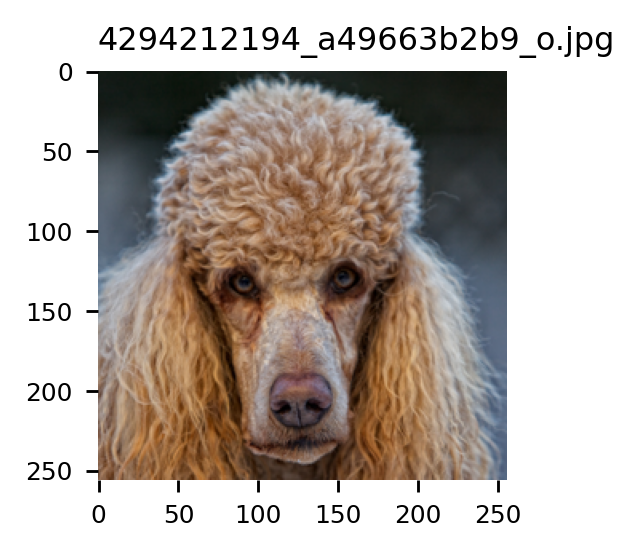

,query,score
0,a poodle,0.290771
1,a dog,0.261230
2,animal outside a car,0.232056
3,animal inside a car,0.220459
4,a sleeping dog,0.208984
5,ipod,0.208008
6,some animals,0.207520
7,a giraffe,0.207397
8,a cat,0.205444
9,a elephant,0.198242


------------------------------------------------------------


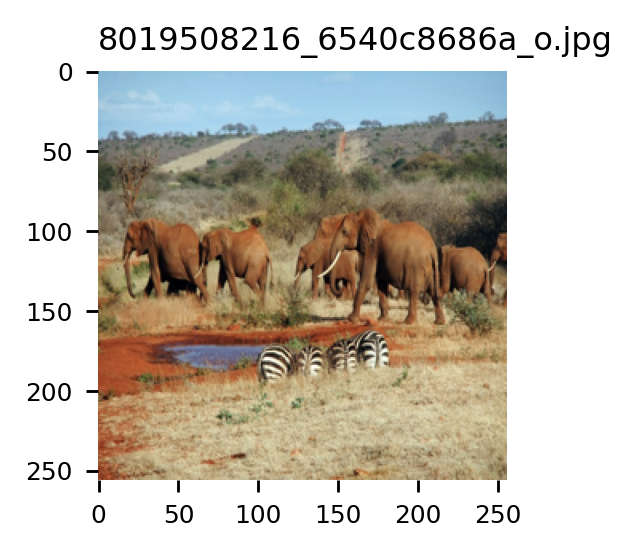

,query,score
0,a elephant,0.258057
1,a zebra,0.249268
2,some animals,0.242920
3,a giraffe,0.224243
4,animal outside a car,0.220093
5,animal inside a car,0.192383
6,three mugs,0.187988
7,blue sky,0.180054
8,ipod,0.176514
9,two mugs,0.175415


------------------------------------------------------------


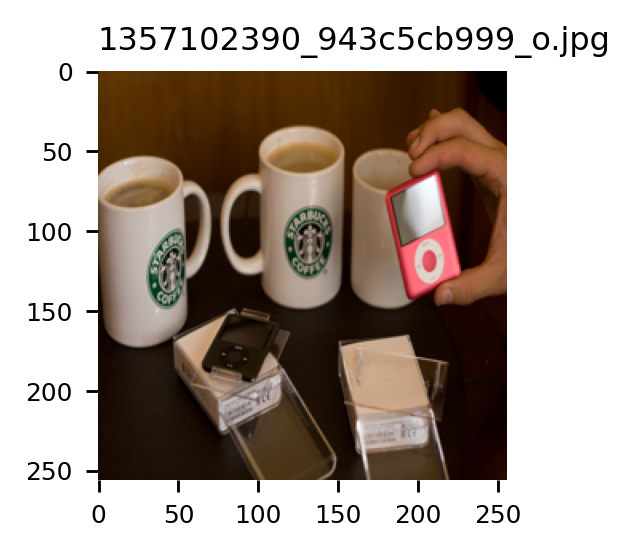

,query,score
0,three mugs,0.246216
1,two mugs,0.233765
2,ipod,0.221558
3,a sofa,0.180420
4,some animals,0.172729
5,santa claus,0.171143
6,a elephant,0.164551
7,blue sky,0.157593
8,a giraffe,0.156616
9,a zebra,0.152222


------------------------------------------------------------


In [9]:
from pathlib import Path
import time, random, subprocess, contextlib, warnings
import numpy as np, pandas as pd
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import torch, clip

# Display tweaks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.set_option("display.float_format", lambda v: f"{v:0.6f}")

# Handle occasional truncated downloads cleanly
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

# 0) CLIP model (uses existing globals if already loaded)
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

def ensure_clip_loaded():
    global model, preprocess
    if "model" in globals() and "preprocess" in globals():
        return model, preprocess
    # Prefer local weights to avoid SSL downloads
    local_weight = Path("../assets/clip/ViT-B-32.pt")
    if not local_weight.exists():
        raise FileNotFoundError(
            "CLIP weights not found at ../assets/clip/ViT-B-32.pt.\n"
            "Place ViT-B-32.pt there (e.g., from a Kaggle CLIP weights dataset) and re-run."
        )
    m, pp = clip.load(str(local_weight), device=device)
    m.eval()
    model, preprocess = m, pp
    return model, preprocess

model, preprocess = ensure_clip_loaded()
print("Device:", device)

# 1) Image fetching with 429-safe backoff (never raises)
urls = [
    "https://farm8.staticflickr.com/6036/6426668771_b5b915e46c_o.jpg",
    "https://c6.staticflickr.com/8/7457/10806045045_02d3dbdcee_o.jpg",
    "https://c1.staticflickr.com/4/3267/2888764405_0a0a608604_o.jpg",
    "https://farm8.staticflickr.com/4028/4294212194_a49663b2b9_o.jpg",
    "https://c5.staticflickr.com/9/8173/8019508216_6540c8686a_o.jpg",
    "https://farm3.staticflickr.com/1146/1357102390_943c5cb999_o.jpg",
]
download_dir = Path("./demo_images"); download_dir.mkdir(exist_ok=True)

def valid_image(p: Path) -> bool:
    try:
        with Image.open(p) as im:
            im.verify()
        return True
    except Exception:
        return False

def fetch_with_backoff(url: str, dest: Path, tries: int = 6) -> bool:
    ua = "Mozilla/5.0 (Macintosh) AppleWebKit/537.36 (KHTML, like Gecko) Chrome Safari"
    for t in range(tries):
        if dest.exists():
            try: dest.unlink()
            except Exception: pass
        cmd = [
            "curl","-L","--fail","--silent","--show-error",
            "-H", f"User-Agent: {ua}",
            "-H", "Accept: image/*",
            "-H", "Referer: https://www.flickr.com/",
            url,"-o",str(dest)
        ]
        res = subprocess.run(cmd)
        if res.returncode == 0 and valid_image(dest):
            return True
        time.sleep(min(60, (2 ** t) + random.random()))
    return False

files = []
for url in urls:
    name = url.rsplit("/", 1)[-1]
    p = download_dir / name
    ok = p.exists() and valid_image(p)
    if not ok:
        print(f"Fetching: {name}")
        ok = fetch_with_backoff(url, p)
    if ok:
        files.append(str(p))

# Fallback: top-N PetFinder training images if any remote fetches failed
if len(files) < 6:
    print("Falling back to local PetFinder images…")
    DATA = Path("../data/raw")
    train_csv = pd.read_csv(DATA/"train.csv")
    needed = 6 - len(files)
    for id_ in train_csv["Id"].head(needed).tolist():
        files.append(str((DATA/"train"/f"{id_}.jpg").resolve()))

print("Images to score:", files)

# 2) Compact 256×256 viewer (like your small screenshot)
def show256_small(path, ticks=True, px=256, title_loc="left"):
    img = Image.open(path).convert('RGB').resize((256, 256), Image.BICUBIC)
    dpi = 128
    fig_w = px / dpi; fig_h = px / dpi
    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)

    ax.imshow(np.asarray(img))
    for s in ax.spines.values():
        s.set_visible(False)

    if ticks:
        ax.set_xticks(np.arange(0, 257, 50))
        ax.set_yticks(np.arange(0, 257, 50))
        ax.tick_params(labelsize=7)
    else:
        ax.axis('off')

    ax.set_title(Path(path).name, fontsize=9, loc=title_loc, pad=6)
    plt.tight_layout(pad=0.1)
    plt.show()

# 3) CLIP scoring (vectorized text; AMP on CUDA only)
QUERIES = [
    "a dog","a cat","a elephant","a zebra","a sleeping dog","a sleeping cat",
    "a giraffe","a poodle","animal inside a car","animal outside a car",
    "a sofa","some animals","santa claus","ipod","two mugs","three mugs","blue sky",
]

def amp_ctx():
    return torch.amp.autocast(device_type="cuda") if device == "cuda" else contextlib.nullcontext()

with torch.no_grad():
    # Pre-encode text once
    tokens = clip.tokenize(QUERIES).to(device)
    with amp_ctx():
        text_emb = model.encode_text(tokens)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

    for fp in files:
        # compact 256×256 image preview
        show256_small(fp, ticks=True, px=256)

        # CLIP image features
        img = Image.open(fp).convert("RGB")
        x = preprocess(img).unsqueeze(0).to(device)
        with amp_ctx():
            image_emb = model.encode_image(x)
        image_emb = image_emb / image_emb.norm(dim=-1, keepdim=True)

        # Cosine similarities
        sims = (image_emb @ text_emb.T).squeeze(0).detach().cpu().numpy()
        df = pd.DataFrame({"query": QUERIES, "score": sims}).sort_values("score", ascending=False).reset_index(drop=True)
        display(df)
        print("-"*60)
